# Online non-linear regression with corrupted observations

In [1]:
import jax
import optax
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
from functools import partial
from rebayes_mini import callbacks
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import gauss_filter as gf
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "E-ANN-1": "crimson",
    "WLF-IMQ": "dodgerblue",
    "EKF": "lightseagreen",
    "WLF-MD": "gold", # TODO: make more o-paco
    "OGD": "blueviolet"
}

## Data-generating process

In [3]:
c1, c2, c3, c4 = 1 / 5, -10, 1.0, 1.0
def f(x):
    return c1 * x + c2 * jnp.cos(c3 * jnp.pi * x) + c4 * x ** 3


def sample_observations_grid(
    key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0, p_corrupt=0.1, ycorr_max=100,
    is_sorted=False
):
    key_x, key_y, key_shuffle, key_corrupted = jax.random.split(key, 4)
    
    key_cchoice, key_cval = jax.random.split(key_corrupted)
    is_corrupted = jax.random.bernoulli(key_cchoice, p=p_corrupt, shape=(n_obs,))
    ycorr = jax.random.uniform(key_cval, (n_obs,), minval=-ycorr_max, maxval=ycorr_max)
    
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jax.random.uniform(key_x, (n_obs,), minval=xmin, maxval=xmax)
    y = f(x) + y_noise
    
    y = y * (1 - is_corrupted) + ycorr * is_corrupted
    
    X = jnp.c_[x, y]
    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    
    if is_sorted:
        ixs_sort = jnp.argsort(x)
        x, y = jnp.array(X[ixs_sort, :].T)
    
    return x, y

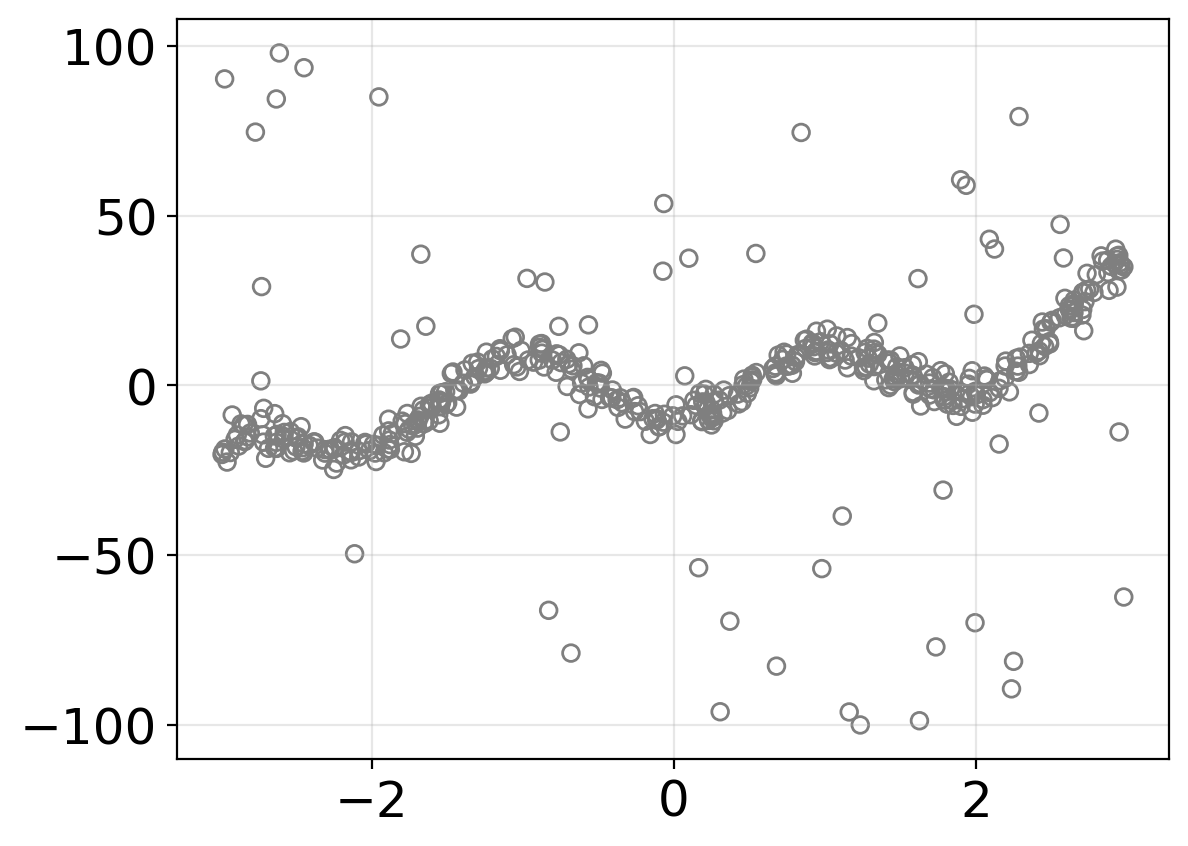

In [43]:
key = jax.random.PRNGKey(314)
key_train, key_sample_obs, key_eval = jax.random.split(key, 3)

n_obs = 500
xmin, xmax = -3, 3
sigma_y = 3.0
ycorrupted = 100
is_sorted = True
is_sorted_str = "sorted" if is_sorted else "unsorted"
x, y = sample_observations_grid(
    key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.2, y_noise=sigma_y, p_corrupt=0.15,
    ycorr_max=ycorrupted, is_sorted=is_sorted
)
xtest = jnp.linspace(x.min(), x.max(), n_obs)
ytest = f(xtest)
plt.scatter(x, y, edgecolors="tab:gray", color="none")
plt.grid(alpha=0.3)

## Filtering

In [44]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [45]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x
    

class DGenFn(nn.Module):
    """
    True (non-noisy) data-generating process
    """
    init_var: float = nn.initializers.normal()
        
    @nn.compact
    def __call__(self, x):
        c1 = self.param("c1", self.init_var, (1,))
        c2 = self.param("c2", self.init_var, (1,))
        c3 = self.param("c3", self.init_var, (1,))
        c4 = self.param("c4", self.init_var, (1,))
        
        return c1 * x + c2 * jnp.cos(c3 * jnp.pi * x) + c4 * x ** 3

    
def latent_fn(x): return x

model_str = "mlp"

if model_str == "mlp":
    model = MLP()
elif model_str == "dgen":
    model = DGenFn()
else:
    raise ValueError("Model type no avaialble")

### Setup
Parameters shared for all methods

In [46]:
from jax.flatten_util import ravel_pytree

In [47]:
dynamics_covariance = 1e-4
observation_covariance = 1.0

cov_init = 1.0
params_init = model.init(key_train, x[:, None])

n_params, _ = ravel_pytree(params_init)
n_params = len(n_params)
Q = jnp.eye(n_params) * dynamics_covariance


### Extended Kalman Filter

In [48]:
def filter_ekf(log_lr):
    lr = np.exp(log_lr)
    
    agent = gf.ExtendedKalmanFilter(
            latent_fn, model.apply, dynamics_covariance=Q,
            observation_covariance=observation_covariance * jnp.eye(1),
        )
    
    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent, bel)
    
    return yhat_pp.squeeze(), out


def opt_step(log_lr):
    res = -jnp.power(filter_ekf(log_lr)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res):
        res = -1e+6
    
    return res

In [49]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 4         | -18.85    | -1.084    |
| 5         | -17.45    | -0.41     |
CPU times: user 3min 52s, sys: 2min 49s, total: 6min 42s
Wall time: 42.2 s


In [50]:
log_lr = bo.max["params"]["log_lr"]
lr_ekf = np.exp(log_lr)

yhat_pp_ekf, (agent_ekf, bel_ekf) = filter_ekf(log_lr)
yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()

### Robust Extended Kalman Filter

In [51]:
def filter_rkf(log_lr, noise_scaling):
    lr = np.exp(log_lr)
    agent_rekf = rfilter.ExtendedRobustKalmanFilter(
        latent_fn, model.apply, dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance * jnp.eye(1),
        noise_scaling=noise_scaling,
        n_inner=1
    )
    
    bel_init = agent_rekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, yhat_pp = agent_rekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_rekf, bel_rekf)
    
    return yhat_pp.squeeze(), out

def opt_step(log_lr, noise_scaling):
    res = -jnp.power(filter_rkf(log_lr, noise_scaling)[0] - y, 2)
    res = jnp.median(res)
    
    if np.isnan(res):
        res = -1e+6
    
    return res

In [52]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "noise_scaling": (1e-6, 20)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | noise_... |
-------------------------------------------------
| 12        | -8.94     | -1.085    | 11.71     |
| 16        | -8.455    | -0.4029   | 13.53     |
CPU times: user 2min 49s, sys: 2min 50s, total: 5min 40s
Wall time: 19.5 s


In [53]:
noise_scaling = bo.max["params"]["noise_scaling"]
log_lr = bo.max["params"]["log_lr"]
lr_rkef = np.exp(log_lr)

yhat_pp_rekf, (agent_rekf, bel_rekf) = filter_rkf(log_lr, noise_scaling)
yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

### Inverse Multi-quadratic filter

In [54]:
def filter_imqf(log_lr, soft_threshold):
    lr = np.exp(log_lr)
    agent_imq = gbfilter.IMQFilter(
        model.apply, dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold
    )

    bel_init = agent_imq.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_imq.link_fn)
    bel_imq, yhat_pp = agent_imq.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_imq, bel_imq)
    return yhat_pp.squeeze(), out


def opt_step(log_lr, soft_threshold):
    res = -jnp.power(filter_imqf(log_lr, soft_threshold)[0] - y, 2)
    res = jnp.median(res)
    
    if np.isnan(res):
        res = -1e+6
    
    return res

In [55]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "soft_threshold": (1e-6, 20),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | soft_t... |
-------------------------------------------------
| 3         | -7.365    | -0.41     | 16.55     |
CPU times: user 3min 53s, sys: 2min 53s, total: 6min 46s
Wall time: 41.9 s


In [56]:
soft_threshold = bo.max["params"]["soft_threshold"]
log_lr = bo.max["params"]["log_lr"]
lr_imq = np.exp(log_lr)

yhat_pp_imq, (agent_imq, bel_imq) = filter_imqf(log_lr, soft_threshold)
yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()

## Weighted-likelihood filter / Mahalanobis distance

In [57]:
def filter_mah_ekf(log_lr, threshold):
    lr = np.exp(log_lr)
    agent_mekf = rfilter.ExtendedThresholdedKalmanFilter(
        latent_fn, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        threshold=threshold
    )
    
    bel_init = agent_mekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    
    bel_mekf, yhat_pp = agent_mekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_mekf, bel_mekf)
    return yhat_pp.squeeze(), out


def opt_step(log_lr, threshold):
    res = -jnp.power(filter_mah_ekf(log_lr, threshold)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res):
        res = -1e+6
    
    return res

In [58]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "threshold": (1e-6, 20)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | threshold |
-------------------------------------------------
| 2         | -9.151    | -3.675    | 15.66     |
| 10        | -8.075    | -2.076    | 11.62     |
| 11        | -8.07     | -2.664    | 13.61     |
CPU times: user 3min 51s, sys: 2min 50s, total: 6min 42s
Wall time: 44.2 s


In [59]:
threshold = bo.max["params"]["threshold"]
log_lr = bo.max["params"]["log_lr"]
lr_mekf = np.exp(log_lr)

yhat_pp_mekf, (agent_mekf, bel_mekf) = filter_mah_ekf(log_lr, threshold)
yhat_mekf = agent_mekf.vobs_fn(bel_mekf.mean, xtest[:, None]).ravel()

## Online gradient descent

In [60]:
def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()


def filter_ogd(log_lr, n_inner):
    lr = np.exp(log_lr)
    n_inner = int(n_inner)
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        optax.adam(lr),
        buffer_size=1,
        dim_features=1,
        dim_output=1,
        n_inner=n_inner,
    )
    
    bel_init = agent.init_bel(params_init)
    callback = partial(callback_fn, applyfn=agent.apply_fn)
    
    bel, yhat_pp = agent.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent, bel)
    return yhat_pp.squeeze(), out



def opt_step(log_lr, n_inner):
    res = -jnp.power(filter_ogd(log_lr, n_inner)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res):
        res = -1e+6
    
    return res

In [61]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "n_inner": (1, 10)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   |  n_inner  |
-------------------------------------------------
| 3         | -26.48    | -0.41     | 8.446     |
| 13        | -26.43    | 0.0       | 9.618     |
| 14        | -25.73    | -1.184    | 9.749     |
| 29        | -25.47    | -0.864    | 8.019     |
| 33        | -23.92    | -0.614    | 4.683     |
CPU times: user 2min 59s, sys: 2min 57s, total: 5min 56s
Wall time: 26.6 s


In [62]:
n_inner = int(bo.max["params"]["n_inner"])
log_lr = bo.max["params"]["log_lr"]
lr_ogd = np.exp(log_lr)

yhat_pp_ogd, (agent_ogd, bel_ogd) = filter_ogd(log_lr, n_inner)

# Plots

In [63]:
pp_elements = {
    "EKF": yhat_pp_ekf,
    "E-ANN-1": yhat_pp_rekf,
    "WLF-MD": yhat_pp_mekf,
    "WLF-IMQ": yhat_pp_imq,
    "OGD": yhat_pp_ogd,
}

pp_elements = jax.tree_map(lambda x: np.squeeze(np.array(x)), pp_elements)

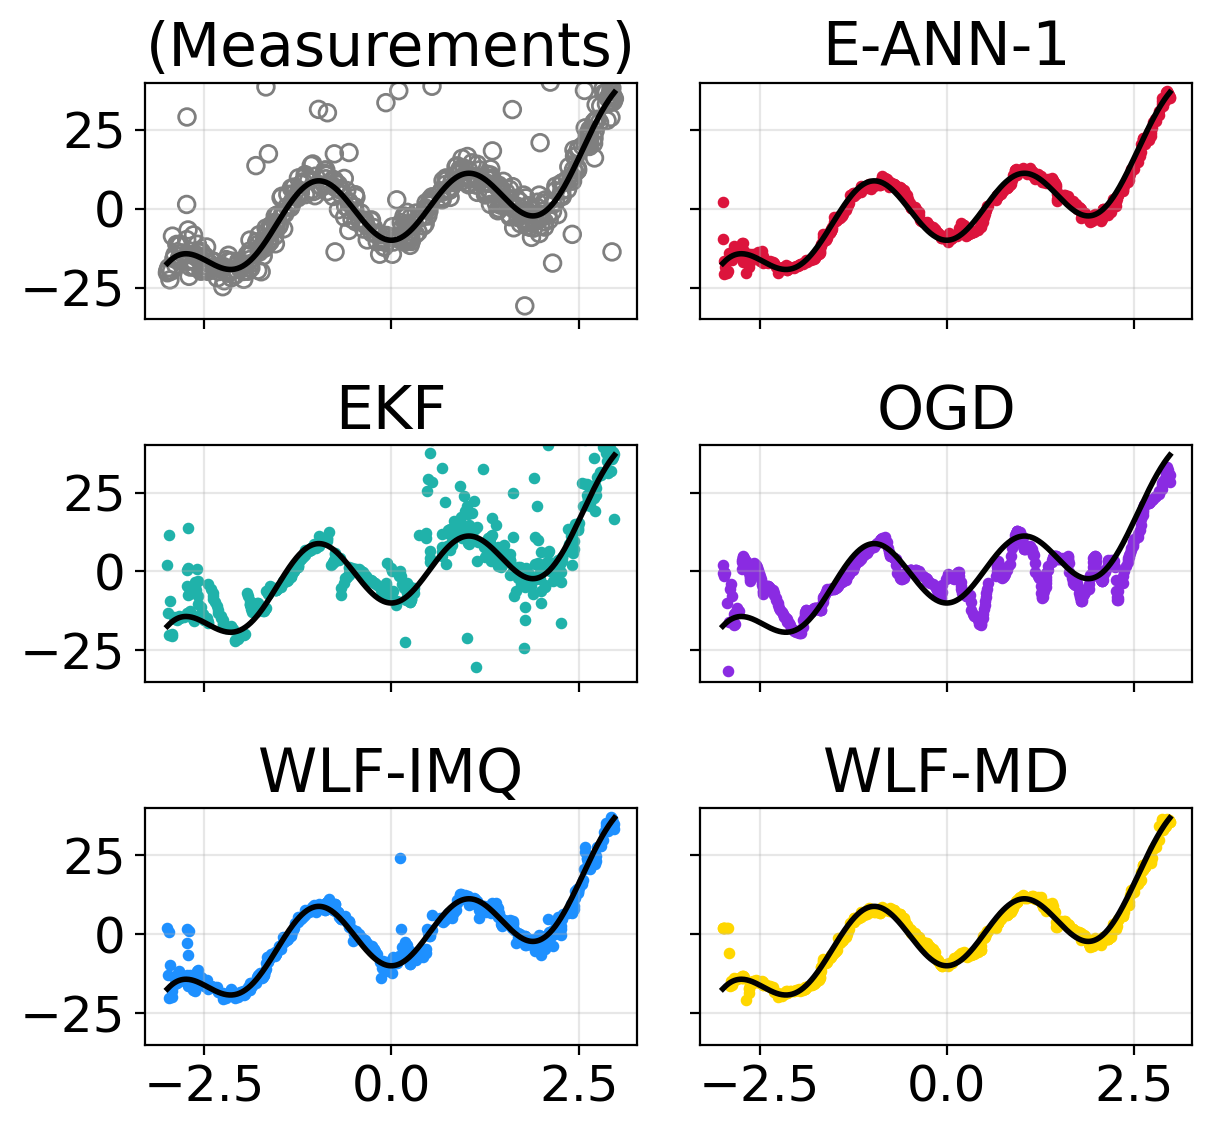

In [64]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(6.4, 4.8 * 2.5 / 2))
axs = axs.ravel()

for ax, method in zip(axs[1:], pp_elements):
    c = cmap[method]
    ax.scatter(x, pp_elements[method], c=c, s=10)
    ax.set_ylim(-35, 40)
    ax.grid(alpha=0.3)
    ax.plot(xtest, ytest, c="black", linewidth=2)
    ax.set_title(method)

axs[0].scatter(x, y, edgecolors="tab:gray", color="none")
axs[0].grid(alpha=0.3)
axs[0].plot(xtest, ytest, c="black", linewidth=2)
axs[0].set_title("(Measurements)")


plt.tight_layout()
plt.savefig(f"./figures/online-{model_str}-{is_sorted_str}-sample.pdf")

## Multiple runs

In [65]:
ytest = f(xtest)
n_obs = 1500
@jax.jit
@jax.vmap
def sample_and_eval(key):
    key_train, key_sample_obs, key_eval = jax.random.split(key, 3)
    x, y = sample_observations_grid(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=sigma_y)
    params_init = model.init(key_train, x[:, None])
    
    bel_init = agent_ekf.init_bel(params_init, cov=lr_ekf)
    callback = partial(callback_fn, applyfn=agent_ekf.vobs_fn)
    bel_ekf, ekf_hist = agent_ekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()
    
    bel_init = agent_rekf.init_bel(params_init, cov=lr_rkef)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, rekf_hist = agent_rekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

    bel_init = agent_imq.init_bel(params_init, cov=lr_imq)
    callback = partial(callback_fn, applyfn=agent_imq.link_fn)
    bel_imq, imq_hist = agent_imq.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()
    
    
    bel_init = agent_mekf.init_bel(params_init, cov=lr_mekf)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    bel_mekf, mekf_hist = agent_mekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_mekf = agent_mekf.vobs_fn(bel_mekf.mean, xtest[:, None]).ravel()
    
    bel_init = agent_ogd.init_bel(params_init)
    callback = partial(callback_fn, applyfn=agent_ogd.apply_fn)
    bel_ogd, ogd_hist = agent_ogd.scan(bel_init, y, x[:, None], callback_fn=callback)
    # yhat_ogd = agent_mekf.vobs_fn(bel_mekf.mean, xtest[:, None]).ravel()



    errs = {
        "E-ANN-1": yhat_rekf,
        "WLF-IMQ": yhat_imq,
        "EKF": yhat_ekf,
        "M-EKF": yhat_mekf,
    }
    
    # One-step-ahead errors
    errs_osa = {
        "E-ANN-1": rekf_hist,
        "WLF-IMQ": imq_hist,
        "EKF": ekf_hist,
        "WLF-MD": mekf_hist,
        "OGD": ogd_hist,
    }
    errs_osa = jax.tree_map(lambda yhat: yhat.squeeze() - y, errs_osa)
        
    
    errs = jax.tree_map(lambda yhat: jnp.sqrt(jnp.power(yhat - ytest, 2).mean()), errs)
    
    return errs, errs_osa

In [66]:
from jax.sharding import PositionalSharding
devices = jax.devices()
sharding = PositionalSharding(devices)

In [67]:
%%time
n_sims = 104
keys = jax.random.split(key_eval, n_sims)
keys = jax.device_put(keys, sharding.reshape(4, 2))

results, errs_osa = sample_and_eval(keys)
results = jax.tree_map(np.array, results)
errs_osa = jax.tree_map(lambda x: np.array(x.squeeze()), errs_osa)
results_df = pd.DataFrame(results)

CPU times: user 27.1 s, sys: 2.98 s, total: 30.1 s
Wall time: 2min 29s


In [68]:
def running_mean(errs):
    errs = errs[:, 0:]
    _, nsteps = errs.shape
    # return np.sqrt(np.power(errs, 2).cumsum(axis=1) / np.arange(1, nsteps + 1)[None])
    return jnp.sqrt(np.power(errs, 2).cumsum(axis=1))

errs_rmean = jax.tree_map(running_mean, errs_osa)

/tmp/ipykernel_2138009/3618293350.py:5: RuntimeWarning: overflow encountered in power
  return jnp.sqrt(np.power(errs, 2).cumsum(axis=1))
/tmp/ipykernel_2138009/3618293350.py:5: RuntimeWarning: overflow encountered in accumulate
  return jnp.sqrt(np.power(errs, 2).cumsum(axis=1))


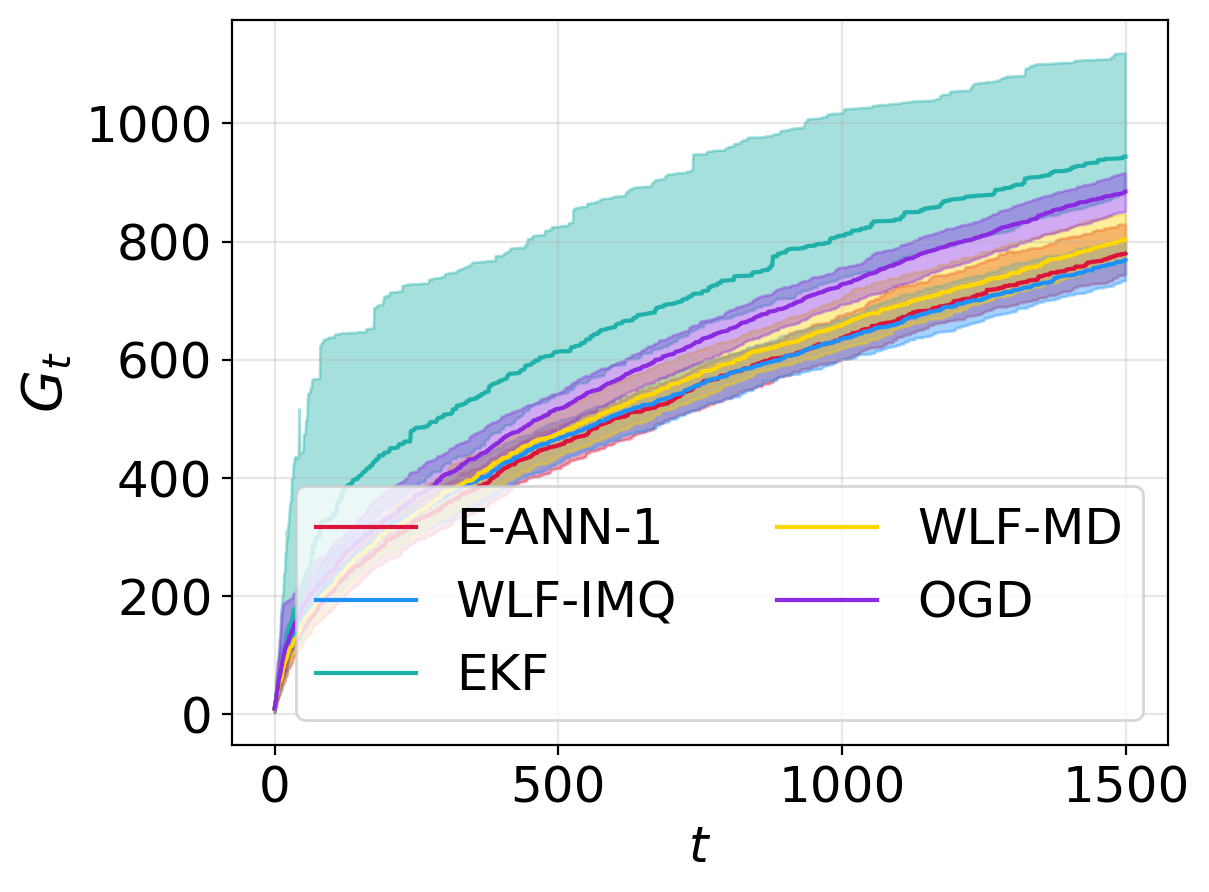

In [69]:
for method in cmap:
    plt.plot(np.nanquantile(errs_rmean[method], 0.5, axis=0), c=cmap[method], label=method)
    vmin, vmax = np.nanquantile(errs_rmean[method], [0.2, 0.8], axis=0)
    plt.fill_between(np.arange(len(vmin)), vmin, vmax, color=cmap[method], alpha=0.4)

# plt.yscale("log")
plt.legend(ncol=2, loc="lower right")
plt.grid(alpha=0.3)
plt.xlabel("$t$")
plt.ylabel("$G_t$", fontsize=20)
plt.tight_layout()
ymin, _ = plt.ylim()
# plt.ylim(ymin, 800)
plt.savefig(f"./figures/online-{model_str}-{is_sorted_str}-osa-benchmark.pdf")

In [70]:
results_osa_df = jax.tree_map(lambda errs: jnp.sqrt(jnp.median(jnp.power(errs, 2)[:, 0:], axis=1)), errs_osa)
results_osa_df = pd.DataFrame(results_osa_df)
results_osa_df.describe()

,E-ANN-1,EKF,OGD,WLF-IMQ,WLF-MD
count,102.000000,101.000000,104.000000,104.000000,104.000000
mean,4.727311,7.918355,10.215705,4.050722,5.082210
std,1.519906,0.931173,0.311013,0.921060,1.021986
min,2.908402,5.787689,9.380205,3.103987,3.556502
25%,3.904196,7.304441,10.013522,3.492669,4.419491
50%,4.337059,7.943721,10.193203,3.845226,4.960686
75%,5.125852,8.550206,10.440926,4.292194,5.358593
max,13.410334,9.890629,10.878801,9.928828,9.448781


In [71]:
def format_entry(entry):
    entry = entry[entry < 1000]
    mean = entry.mean()
    std = entry.std()
    if std > 1000:
        label = rf"$-$"
    else:
        label = rf"${mean:0.3f} \pm {std:0.3f}$"
    return label

In [72]:
is_sorted_str

'sorted'

In [73]:
res = results_osa_df.melt().groupby("variable")["value"].apply(format_entry)
res

variable
E-ANN-1     $4.727 \pm 1.520$
EKF         $7.918 \pm 0.931$
OGD        $10.216 \pm 0.311$
WLF-IMQ     $4.051 \pm 0.921$
WLF-MD      $5.082 \pm 1.022$
Name: value, dtype: object

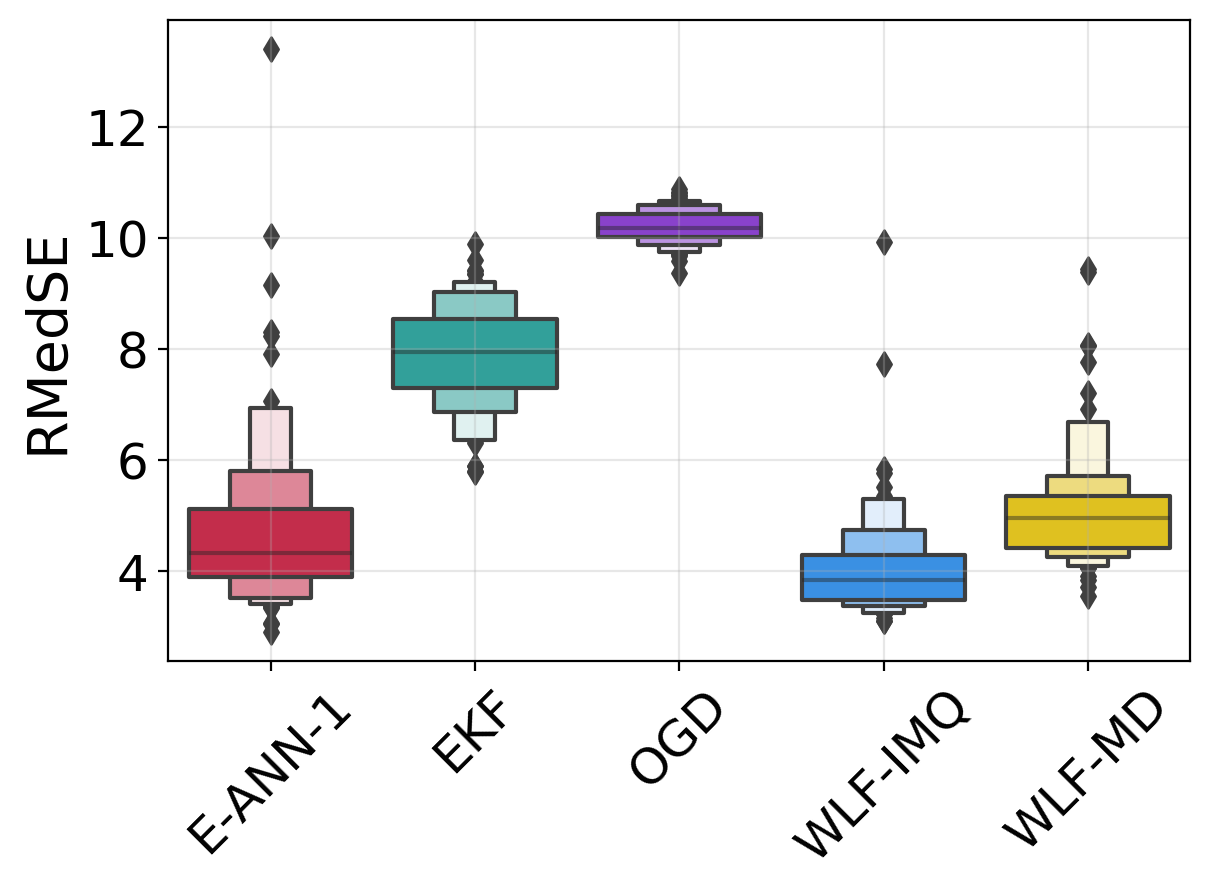

In [76]:
sns.boxenplot(
    (
    results_osa_df
        .melt()
        # .query("value < 1000")
    )
    ,
    x="variable", y="value",
    palette=cmap
)
plt.grid(alpha=0.3)
# plt.yscale("log")
plt.xlabel("")
plt.ylabel("RMedSE", fontsize=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"./figures/online-{model_str}-{is_sorted_str}-benchmark.pdf")